<a href="https://colab.research.google.com/github/namakutiwik/New-York-CitiBike/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Install Mount Drive & Import Dataset***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

adc.json  drive  sample_data  stations.csv


In [ ]:
import pandas as pd

CHUNK_SIZE = 50000
csv_file_list = ["/content/drive/My Drive/Kemenkes - Data Analyst/data2015.csv", 
                 "/content/drive/My Drive/Kemenkes - Data Analyst/data2016.csv", 
                 "/content/drive/My Drive/Kemenkes - Data Analyst/data2017.csv"]
output_file = "output.csv"

first_one = True
for csv_file_name in csv_file_list:

    if not first_one: # if it is not the first csv file then skip the header row (row 0) of that file
        skip_row = [0]
    else:
        skip_row = []

    chunk_container = pd.read_csv(csv_file_name, chunksize=CHUNK_SIZE, skiprows = skip_row)
    for chunk in chunk_container:
        chunk.to_csv(output_file, mode="a", index=False)
    first_one = False

In [ ]:
output = pd.read_csv('/content/output.csv', chunksize=50000)
trips = pd.concat(output)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,3,5,6,7,9,10,11,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12,8)

# Import Dataset from API Bigquery

##### **For station dataset**

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project my-first-project-318200 df
SELECT 
  *
FROM `bigquery-public-data.new_york_citibike.citibike_stations`

In [ ]:
stations = df
stations.head(2)

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,116,W 17 St & 8 Ave,6148.02,40.741776,-74.001497,71.0,"CREDITCARD,KEY",0,False,0,0,0,0,True,True,True,False,1970-01-01
1,173,Broadway & W 49 St,6708.02,40.760683,-73.984527,71.0,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,False,1970-01-01


In [ ]:
stations.to_csv (r'stations.csv', index = False, header=True)

##### **For trip dataset**

In [ ]:
# it is to only get the sample with random index

project_id = 'my-first-project-318200'

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 58937715 rows


In [ ]:
trips = df
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,2103.0,2017-11-15 09:42:11,2017-11-15 10:17:14,261.0,Johnson St & Gold St,40.694749,-73.983625,285.0,Broadway & E 14 St,40.734546,-73.990741,31202.0,Subscriber,1946.0,female,
1,692.0,2016-06-12 20:38:45,2016-06-12 20:50:18,502.0,Henry St & Grand St,40.714215,-73.981346,349.0,Rivington St & Ridge St,40.718502,-73.983299,24076.0,Subscriber,2000.0,male,


In [ ]:
len(trips)

2023

# Exploratory Data Analysis



*  Top 5 stations with the most starts (showing # of starts)
* Trip duration by user type
* Most popular trips based on start station and stop station)
* Rider behaviour by Gender and Age based on avg trip distance (station to station), median speed (trip duration / distance traveled)
* What is the busiest bike in NYC? How many times was it used? How many minutes was it in use?





Information of trip dataset:
1. Trip Duration (seconds) — How long a trip lasted
2. Start Time and Date - Self explanatory
3. Stop Time and Date - Self explanatory
4. Start Station Name - Self explanatory
5. End Station Name - Self explanatory
6. Station ID - Unique identifier for each station
7. Station Lat/Long - Coordinates
8. Bike ID - unique identifier for each bike
9. User Type (Customer = 24-hour pass or 3-day pass user;  Subscriber = Annual Member) - Customers are usually tourists, subscribers are usually NYC residents
10. Gender (Zero=unknown; 1=male; 2=female) - Usually unknown for customers since they often sign up at a kiosk
11. Year of Birth - Self entered, not validated by an ID.



## Cleaning Trips Dataset

### General

In [ ]:
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,2103.0,2017-11-15 09:42:11,2017-11-15 10:17:14,261.0,Johnson St & Gold St,40.694749,-73.983625,285.0,Broadway & E 14 St,40.734546,-73.990741,31202.0,Subscriber,1946.0,female,
1,692.0,2016-06-12 20:38:45,2016-06-12 20:50:18,502.0,Henry St & Grand St,40.714215,-73.981346,349.0,Rivington St & Ridge St,40.718502,-73.983299,24076.0,Subscriber,2000.0,male,


In [ ]:
# Extract year from startime to get the trips' year
trips['trips_year'] = pd.DatetimeIndex(trips['starttime']).year
trips.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,trips_year
0,2103.0,2017-11-15 09:42:11,2017-11-15 10:17:14,261.0,Johnson St & Gold St,40.694749,-73.983625,285.0,Broadway & E 14 St,40.734546,-73.990741,31202.0,Subscriber,1946.0,female,,2017.0
1,692.0,2016-06-12 20:38:45,2016-06-12 20:50:18,502.0,Henry St & Grand St,40.714215,-73.981346,349.0,Rivington St & Ridge St,40.718502,-73.983299,24076.0,Subscriber,2000.0,male,,2016.0
2,590.0,2016-02-03 10:12:27,2016-02-03 10:22:18,352.0,W 56 St & 6 Ave,40.763406,-73.977225,474.0,5 Ave & E 29 St,40.745168,-73.986831,22060.0,Subscriber,1996.0,male,,2016.0


In [ ]:
pd.unique(trips.trips_year)

array([2017., 2016., 2013., 2015., 2014., 2018.,   nan])

In [ ]:
# Get only dataset 2015-2017
# Get indexes where name column doesn't have value
indexNames = trips[~(trips['trips_year'] == 2015) & ~(trips['trips_year'] == 2016) & ~(trips['trips_year'] == 2017)].index 
# Delete these row indexes from dataFrame
trips.drop(indexNames , inplace=True)

In [ ]:
pd.unique(trips.customer_plan)

array([''], dtype=object)

In [ ]:

# remove unnecessary columns
trips.drop(trips.columns[[15]], axis = 1, inplace = True)

In [ ]:
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year
0,2103.0,2017-11-15 09:42:11,2017-11-15 10:17:14,261.0,Johnson St & Gold St,40.694749,-73.983625,285.0,Broadway & E 14 St,40.734546,-73.990741,31202.0,Subscriber,1946.0,female,2017.0
1,692.0,2016-06-12 20:38:45,2016-06-12 20:50:18,502.0,Henry St & Grand St,40.714215,-73.981346,349.0,Rivington St & Ridge St,40.718502,-73.983299,24076.0,Subscriber,2000.0,male,2016.0


In [ ]:
trips['trips_year'] = trips['trips_year'].astype(int)

### Adjusting Station ID vs Station Name

**Checking the imbalance**

In [ ]:
print(len(unique(trips.start_station_id)))
print(len(unique(trips.end_station_id)))

441
431


In [ ]:
print(len(unique(trips.start_station_name)))
print(len(unique(trips.end_station_name)))

437
430


In [ ]:
id_name_s = trips[['start_station_id','start_station_name','end_station_id', 'end_station_name']]
id_name_s = id_name_s.groupby("start_station_id")
id_name_s = id_name_s.agg({"start_station_name": "nunique"})
id_name_s = id_name_s.reset_index()
len(id_name_s[id_name_s['start_station_name']>=2])

1

In [ ]:
id_name_e = trips[['start_station_id','start_station_name','end_station_id', 'end_station_name']]
id_name_e = id_name_e.groupby("end_station_id")
id_name_e = id_name_e.agg({"end_station_name": "nunique"})
id_name_e = id_name_e.reset_index()
len(id_name_e[id_name_e['end_station_name']>=2])

3

In [ ]:
id_name_e[id_name_e['end_station_name']>=2].head()

,end_station_id,end_station_name
73,312.0,2
104,347.0,2
195,468.0,2


In [ ]:
a = trips[trips['end_station_id']==329.0]
unique(a.end_station_name)

array(['Greenwich St & N Moore St'], dtype=object)

Since the difference, it should use id rather than name

**Create dataframe as dictionary**

In [ ]:
start = trips[['start_station_id', 'start_station_name']]
len(unique(start.start_station_id))

441

In [ ]:
start.drop_duplicates(subset='start_station_id', keep="first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
start.rename(columns = {'start_station_id':'station_id','start_station_name':'station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
end = trips[['end_station_id', 'end_station_name']]
len(unique(end.end_station_id))

431

In [ ]:
end.drop_duplicates(subset='end_station_id', keep="first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
end.rename(columns = {'end_station_id':'station_id','end_station_name':'station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
id_name = pd.concat([start,end])
id_name.drop_duplicates(subset='station_id', keep="first", inplace=True)

In [ ]:
id_name['station_id'] = id_name['station_id'].astype(int)

In [ ]:
id_name.head(3)

,station_id,station_name
0,261,Johnson St & Gold St
1,502,Henry St & Grand St
2,352,W 56 St & 6 Ave


In [ ]:
len(id_name)

544

**Combine the dataframe using lookup func.**

In [ ]:
trips['start_station_id_copy'] = trips['start_station_id']
trips['end_station_id_copy'] = trips['end_station_id']

In [ ]:
trips.start_station_id_copy.replace(dict(zip(id_name.station_id, id_name.station_name)), inplace=True)
trips.end_station_id_copy.replace(dict(zip(id_name.station_id, id_name.station_name)), inplace=True)

In [ ]:
trips.drop(['start_station_name','end_station_name'], 1, inplace=True)

In [ ]:
trips.rename(columns = {'start_station_id_copy':'start_station_name','end_station_id_copy':'end_station_name'}, inplace = True)

In [ ]:
trips.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year,start_station_name,end_station_name
0,2103.0,2017-11-15 09:42:11,2017-11-15 10:17:14,261.0,40.694749,-73.983625,285.0,40.734546,-73.990741,31202.0,Subscriber,1946.0,female,2017,Johnson St & Gold St,Broadway & E 14 St
1,692.0,2016-06-12 20:38:45,2016-06-12 20:50:18,502.0,40.714215,-73.981346,349.0,40.718502,-73.983299,24076.0,Subscriber,2000.0,male,2016,Henry St & Grand St,Rivington St & Ridge St
2,590.0,2016-02-03 10:12:27,2016-02-03 10:22:18,352.0,40.763406,-73.977225,474.0,40.745168,-73.986831,22060.0,Subscriber,1996.0,male,2016,W 56 St & 6 Ave,5 Ave & E 29 St


### Any missing value?

In [ ]:
#Percentage of missing data.
def missing_data(df):
    total = df.isna().sum().sort_values(ascending=False)
    percent = round(df.isna().sum() / len(df), 4) * 100
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(trips)

,Total,Percent
birth_year,158,13.17
end_station_name,0,0.00
start_station_name,0,0.00
trips_year,0,0.00
gender,0,0.00
usertype,0,0.00
bikeid,0,0.00
end_station_longitude,0,0.00
end_station_latitude,0,0.00
end_station_id,0,0.00


In [ ]:
trips[trips['birth_year'].isna()].head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year,start_station_name,end_station_name
3,1280.0,2017-05-09 13:33:38,2017-05-09 13:54:59,3374.0,40.799484,-73.955613,3226.0,40.782750,-73.971370,25462.0,Customer,NaN,unknown,2017,Central Park North & Adam Clayton Powell Blvd,W 82 St & Central Park West
4,942.0,2016-09-24 11:19:44,2016-09-24 11:35:27,518.0,40.747804,-73.973442,482.0,40.739355,-73.999318,24895.0,Customer,NaN,unknown,2016,E 39 St & 2 Ave,W 15 St & 7 Ave
5,1644.0,2017-06-22 22:02:11,2017-06-22 22:29:36,3180.0,40.698780,-73.997120,3180.0,40.698780,-73.997120,15628.0,Customer,NaN,unknown,2017,Brooklyn Bridge Park - Pier 2,Brooklyn Bridge Park - Pier 2
6,982.0,2017-11-02 18:59:38,2017-11-02 19:16:00,361.0,40.716059,-73.991908,2010.0,40.721655,-74.002347,17943.0,Subscriber,NaN,unknown,2017,Allen St & Hester St,Grand St & Greene St
7,3934.0,2017-09-09 14:25:54,2017-09-09 15:31:28,3016.0,40.720368,-73.961651,285.0,40.734546,-73.990741,28316.0,Customer,NaN,unknown,2017,Kent Ave & N 7 St,Broadway & E 14 St


In [ ]:
len(trips[(trips['birth_year'].isna()) & (trips['gender']=='unknown')])

158

In [ ]:
len(trips[(trips['birth_year'].isna()) & (trips['gender']!='unknown')])

0

In [ ]:
trips.dropna(axis = 0, inplace=True)

### Data description

In [ ]:
trips.dtypes

tripduration                      float64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_latitude              float64
end_station_longitude             float64
bikeid                            float64
usertype                           object
birth_year                        float64
gender                             object
trips_year                          int64
start_station_name                 object
end_station_name                   object
dtype: object

In [ ]:
#Ensure data is formatted correctly to avoid errors in the visuals
#trips['starttime'] = pd.to_datetime(trips['starttime'])
#trips['stoptime'] = pd.to_datetime(trips['stoptime'])
trips['start_station_id'] = trips['start_station_id'].astype('category')
trips['end_station_id'] = trips['end_station_id'].astype('category')
trips['bikeid'] = trips['bikeid'].astype('category')
trips['birth_year'] = trips['birth_year'].astype('category')
trips['trips_year'] = trips['trips_year'].astype('category')

In [ ]:
round(trips.describe(),2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
count,1042.00,1042.00,1042.00,1042.00,1042.00
mean,737.74,40.74,-73.99,40.74,-73.99
std,573.97,0.02,0.02,0.02,0.02
min,61.00,40.67,-74.02,40.66,-74.02
25%,358.25,40.72,-74.00,40.72,-74.00
50%,560.50,40.74,-73.99,40.74,-73.99
75%,968.00,40.75,-73.98,40.75,-73.98
max,6386.00,40.81,-73.91,40.80,-73.91


### Remove broken bike data

In [ ]:
#Drop double count
trips = trips.drop(trips.index[(trips['tripduration'] < 90) & 
                  (trips['start_station_name'] == trips['end_station_name'])])

### Remove theft bike data

In [ ]:
trips[trips['usertype']=='Subscriber'].quantile([.1, .25, .5, .75], axis = 0)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0.10,229.2,40.705310,-74.005226,40.703652,-74.005139
0.25,359.0,40.720434,-73.995299,40.720664,-73.997044
0.50,560.0,40.737815,-73.987882,40.736245,-73.989111
0.75,961.0,40.751873,-73.977112,40.751726,-73.977910


In [ ]:
trips[trips['usertype']=='Customer'].quantile([.1, .25, .5, .75], axis = 0)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0.10,695.00,40.711015,-74.010048,40.704487,-74.007979
0.25,1183.75,40.717590,-74.003804,40.709658,-74.001573
0.50,2063.00,40.742549,-73.982469,40.738687,-73.985818
0.75,2652.00,40.764255,-73.974754,40.765909,-73.977736


In [ ]:
trips.quantile([.1, .25, .5, .75], axis = 0)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0.10,229.8,40.705310,-74.005301,40.703632,-74.005139
0.25,359.5,40.720401,-73.995299,40.720315,-73.997045
0.50,563.0,40.737815,-73.987882,40.736245,-73.989111
0.75,968.5,40.751873,-73.977086,40.751726,-73.977910


In [ ]:
#Remove anomalies
trips = trips.drop(trips.index[(trips['tripduration'] >= 7200)])

### Export dataset

In [ ]:
trips.to_csv (r'trips_cleaned.csv', index = False, header=True)

## Part 1: Top 5 Start Stations

In [ ]:
#Data for Top 5 Stations
top5 = trips.groupby('trips_year')['start_station_name'].value_counts().reset_index(name='number_of_start').groupby(['start_station_name']).mean()
top5 = pd.DataFrame(top5.to_records()).sort_values(by=['number_of_start'],ascending=False).head(5)
top5

,start_station_name,number_of_start
185,E 6 St & Avenue B,6.0
338,W 13 St & Hudson St,5.0
139,E 17 St & Broadway,5.0
358,W 33 St & 7 Ave,5.0
83,Broadway & W 60 St,5.0


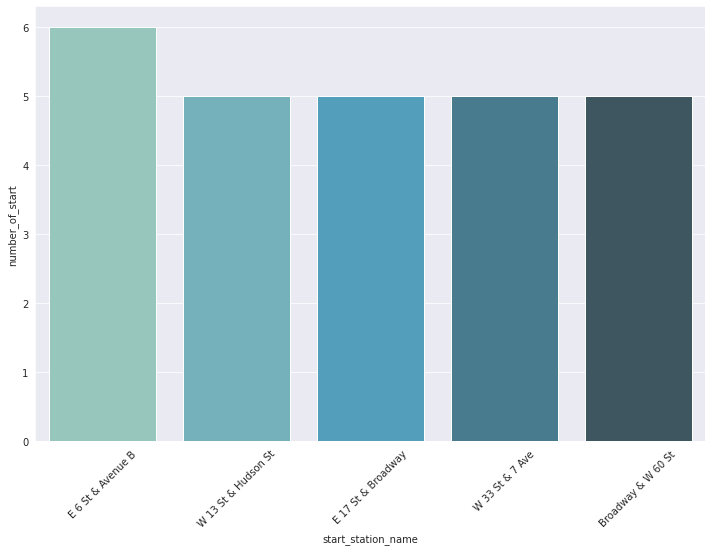

In [ ]:
#Barplot
ax1 = sns.barplot(x='start_station_name', y='number_of_start', data = top5, palette="GnBu_d")
plt.xticks(rotation=45)
plt.show()

## Part 2: Trip Duration by User Type

In [ ]:
#pd.unique(trips.usertype)
a = trips.loc[trips['trips_year'] == 2015]
pd.unique(a.usertype)

array(['Subscriber'], dtype=object)

In [ ]:
#Data for Top 5 Stations visual
TD_user = round(trips.groupby(['trips_year','usertype'])['tripduration'].mean().reset_index(name='avg_tripduration'),2)
TD_user = TD_user.dropna(subset=['avg_tripduration'])
TD_user = pd.DataFrame(TD_user.to_records())
TD_user

,index,trips_year,usertype,avg_tripduration
0,1,2015,Subscriber,691.05
1,2,2016,Customer,2496.00
2,3,2016,Subscriber,742.64
3,4,2017,Customer,1802.60
4,5,2017,Subscriber,753.62


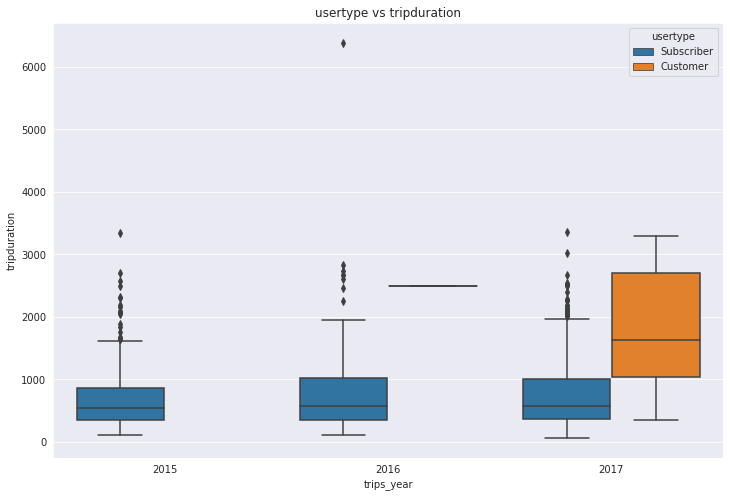

In [ ]:
sns.boxplot(x='trips_year', y='tripduration', hue='usertype', data=trips, showfliers=True)
plt.title("usertype vs tripduration", fontsize= 12)
plt.show()

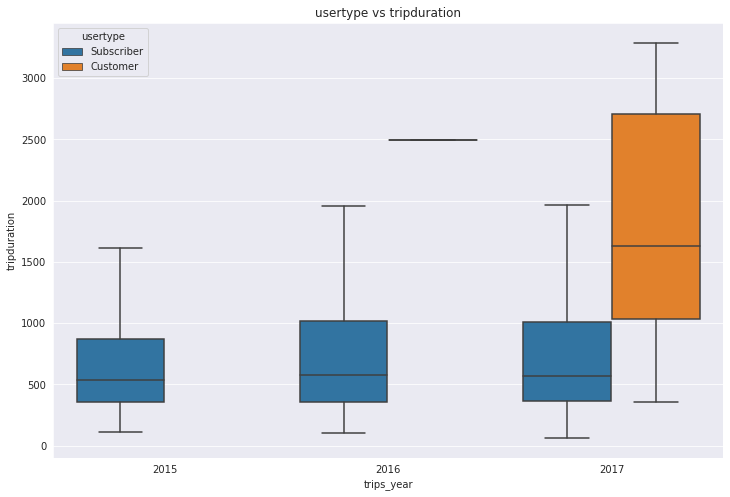

In [ ]:
sns.boxplot(x='trips_year', y='tripduration', hue='usertype', data=trips, showfliers=False)
plt.title("usertype vs tripduration", fontsize= 12)
plt.show()

In [ ]:
len(trips[(trips['usertype']=='Customer') & (trips['trips_year']==2016)])

1

## Part 3: Most Popular Trip

In [ ]:
#Identify the 10 most popular trips
route = pd.DataFrame()
route = trips.groupby(['trips_year','start_station_name','end_station_name']).size().reset_index(name = 'number_of_trips')
route["trip"] = route["start_station_name"] + " -- " + route["end_station_name"]
route = route.drop(['start_station_name', "end_station_name"], axis = 1)
route = route.groupby(['trip'])['number_of_trips'].mean().reset_index(name = 'number_of_trips')
route = route.sort_values('number_of_trips', ascending = False).head(10)
route

,trip,number_of_trips
237,1 Ave & E 15 St -- Lafayette St & E 8 St,1.000000
141334,W 26 St & 8 Ave -- E 17 St & Broadway,1.000000
16532,9 Ave & W 16 St -- E 16 St & 5 Ave,0.666667
51518,E 11 St & 2 Ave -- University Pl & E 14 St,0.666667
31945,Broadway & W 49 St -- W 31 St & 7 Ave,0.666667
27714,Broadway & E 14 St -- Cooper Square & E 7 St,0.666667
52930,E 12 St & 3 Ave -- E 13 St & Avenue A,0.666667
22618,Bank St & Washington St -- Greenwich Ave & 8 Ave,0.666667
66805,E 47 St & 2 Ave -- 1 Ave & E 78 St,0.666667
138050,W 20 St & 11 Ave -- Bank St & Washington St,0.666667


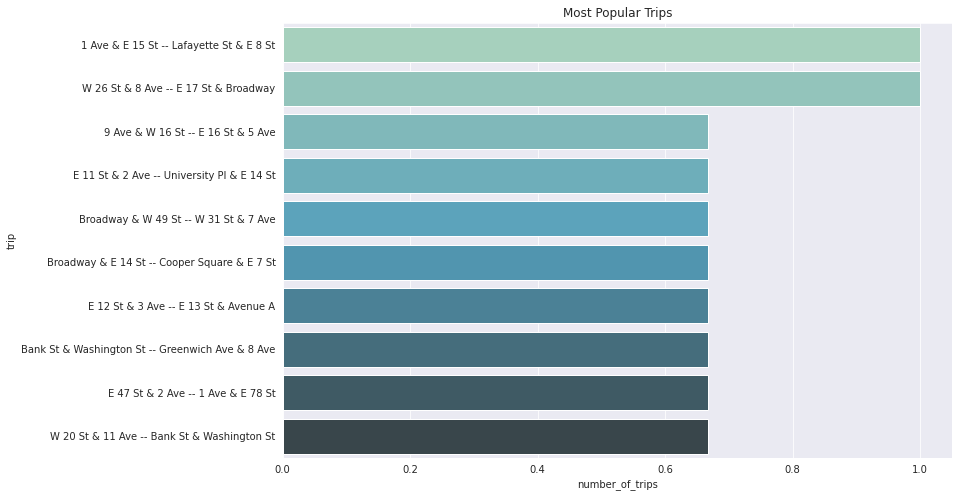

In [ ]:
#Barplot
ax2 = sns.barplot(x='number_of_trips', y='trip', data = route, palette="GnBu_d") #hue='trips_year'
ax2.set_title('Most Popular Trips', fontsize = 12)
plt.show()

## Part 4: Rider Behaviour by Gender and Age

In [ ]:
behav = trips[["tripduration", "start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude", "birth_year", "gender", "trips_year"]]
behav['age'] = 2017 - trips['birth_year'].astype(int)
behav.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,gender,trips_year,age
0,2103.0,40.694749,-73.983625,40.734546,-73.990741,1946.0,female,2017,71
1,692.0,40.714215,-73.981346,40.718502,-73.983299,2000.0,male,2016,17


In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [ ]:
dist = []
for ind in trips.index:
    jarak = round(haversine(behav['start_station_latitude'][ind], behav['start_station_longitude'][ind],
                      behav['end_station_latitude'][ind], behav['end_station_longitude'][ind]),2)
    dist.append((jarak))
cols=['jarak']

result = pd.DataFrame(dist, columns=cols)

In [ ]:
behav['distance'] = dist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#drop circular round trips
behav = behav.drop(behav.index[(behav['distance'] == 0)])

In [ ]:
pd.unique(behav.gender)

array(['female', 'male', 'unknown'], dtype=object)

In [ ]:
len(behav[behav['gender'] == 'unknown'])

1

In [ ]:
len(behav)

1026

In [ ]:
len(behav.index[(behav['age'] >= 100)])

0

In [ ]:
behav['mile_per_hour'] = round(behav['distance']/(behav['tripduration']/3600),2)

In [ ]:
round(behav.describe(),2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,age,distance,mile_per_hour
count,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00
mean,733.45,40.74,-73.99,40.74,-73.99,39.13,1.09,5.68
std,541.70,0.02,0.02,0.02,0.02,11.93,0.82,1.74
min,61.00,40.67,-74.02,40.66,-74.02,17.00,0.11,0.23
25%,362.00,40.72,-74.00,40.72,-74.00,30.00,0.53,4.66
50%,563.00,40.74,-73.99,40.74,-73.99,36.00,0.83,5.67
75%,968.00,40.75,-73.98,40.75,-73.98,47.00,1.42,6.78
max,3351.00,40.81,-73.91,40.80,-73.92,77.00,5.38,11.65


In [ ]:
behav.groupby(['age','gender']).median()['mile_per_hour'].unstack().isnull().sum()

gender
female      6
male        0
unknown    54
dtype: int64

In [ ]:
bin = np.linspace(min(behav['age']), max(behav['age']), 15)
len(bin)

15

In [ ]:
cat = pd.Series(np.arange(1,len(bin)+1,1))
len(cat)

15

In [ ]:
bin = pd.DataFrame(bin)
bin = bin.rename(columns = {0:'bin'})
cat = pd.DataFrame(cat)
cat = cat.rename(columns = {0:'cat'})
age_bin = pd.concat([bin, cat], axis=1)
age_bin['bin2'] = age_bin.bin.shift(1)
age_bin['bin2'] = age_bin['bin2'].replace(np.nan, 0)
age_bin['cat2'] = round(age_bin['bin2'],2).astype(str) + '-' + round(age_bin['bin'],2).astype(str)
age_bin.head()

,bin,cat,bin2,cat2
0,17.000000,1,0.000000,0.0-17.0
1,21.285714,2,17.000000,17.0-21.29
2,25.571429,3,21.285714,21.29-25.57
3,29.857143,4,25.571429,25.57-29.86
4,34.142857,5,29.857143,29.86-34.14


In [ ]:
def f(behav):
    if behav['age'] > age_bin.iloc[0,2] and behav['age'] <= age_bin.iloc[0,0]:
        val = age_bin.iloc[0,1] 
    elif behav['age'] > age_bin.iloc[1,2] and behav['age'] <= age_bin.iloc[1,0]:
        val = age_bin.iloc[1,1]
    elif behav['age'] > age_bin.iloc[2,2] and behav['age'] <= age_bin.iloc[2,0]:
        val = age_bin.iloc[2,1]
    elif behav['age'] > age_bin.iloc[3,2] and behav['age'] <= age_bin.iloc[3,0]:
        val = age_bin.iloc[3,1]
    elif behav['age'] > age_bin.iloc[4,2] and behav['age'] <= age_bin.iloc[4,0]:
        val = age_bin.iloc[4,1]
    elif behav['age'] > age_bin.iloc[5,2] and behav['age'] <= age_bin.iloc[5,0]:
        val = age_bin.iloc[5,1]
    elif behav['age'] > age_bin.iloc[6,2] and behav['age'] <= age_bin.iloc[6,0]:
        val = age_bin.iloc[6,1]
    elif behav['age'] > age_bin.iloc[7,2] and behav['age'] <= age_bin.iloc[7,0]:
        val = age_bin.iloc[7,1]
    elif behav['age'] > age_bin.iloc[8,2] and behav['age'] <= age_bin.iloc[8,0]:
        val = age_bin.iloc[8,1]
    elif behav['age'] > age_bin.iloc[9,2] and behav['age'] <= age_bin.iloc[9,0]:
        val = age_bin.iloc[9,1]
    elif behav['age'] > age_bin.iloc[10,2] and behav['age'] <= age_bin.iloc[10,0]:
        val = age_bin.iloc[10,1]
    elif behav['age'] > age_bin.iloc[11,2] and behav['age'] <= age_bin.iloc[11,0]:
        val = age_bin.iloc[11,1]
    elif behav['age'] > age_bin.iloc[12,2] and behav['age'] <= age_bin.iloc[12,0]:
        val = age_bin.iloc[12,1]
    elif behav['age'] > age_bin.iloc[13,2] and behav['age'] <= age_bin.iloc[13,0]:
        val = age_bin.iloc[13,1]
    else:
        val = age_bin.iloc[14,1]
    return val

#create new column 'Good' using the function above
behav['age_cat'] = behav.apply(f, axis=1)

In [ ]:
behav.head(2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,gender,trips_year,age,distance,mile_per_hour,age_cat
0,2103.0,40.694749,-73.983625,40.734546,-73.990741,1946.0,female,2017,71,2.78,4.76,14
1,692.0,40.714215,-73.981346,40.718502,-73.983299,2000.0,male,2016,17,0.31,1.61,1


In [ ]:
behav_2015 = behav[behav.trips_year == 2015]
speed_age_gender_2015 = behav_2015.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2015.dropna(inplace=True)

In [ ]:
speed_age_gender_2015 = pd.merge(age_bin, speed_age_gender_2015, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2015 = speed_age_gender_2015.drop(['bin','cat','bin2'], axis = 1)

In [ ]:
behav_2015 = behav[behav.trips_year == 2015]
distance_age_gender_2015 = behav_2015.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2015.dropna(inplace=True)

In [ ]:
distance_age_gender_2015 = pd.merge(age_bin, distance_age_gender_2015, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2015 = distance_age_gender_2015.drop(['bin','cat','bin2'], axis = 1)

In [ ]:
behav_2016 = behav[behav.trips_year == 2016]
speed_age_gender_2016 = behav_2016.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2016.dropna(inplace=True)

In [ ]:
speed_age_gender_2016 = pd.merge(age_bin, speed_age_gender_2016, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2016 = speed_age_gender_2016.drop(['bin','cat','bin2'], axis = 1)

In [ ]:
behav_2016 = behav[behav.trips_year == 2016]
distance_age_gender_2016 = behav_2016.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2016.dropna(inplace=True)

In [ ]:
distance_age_gender_2016 = pd.merge(age_bin, distance_age_gender_2016, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2016 = distance_age_gender_2016.drop(['bin','cat','bin2'], axis = 1)

In [ ]:
behav_2017 = behav[behav.trips_year == 2017]
speed_age_gender_2017 = behav_2017.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2017.dropna(inplace=True)

In [ ]:
speed_age_gender_2017 = pd.merge(age_bin, speed_age_gender_2017, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2017 = speed_age_gender_2017.drop(['bin','cat','bin2'], axis = 1)

In [ ]:
behav_2017 = behav[behav.trips_year == 2017]
distance_age_gender_2017 = behav_2017.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2017.dropna(inplace=True)

In [ ]:
distance_age_gender_2017 = pd.merge(age_bin, distance_age_gender_2017, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2017 = distance_age_gender_2017.drop(['bin','cat','bin2'], axis = 1)

In [ ]:
speed_age_gender = pd.concat([speed_age_gender_2015, speed_age_gender_2016, speed_age_gender_2017], axis=0)
speed_age_gender = speed_age_gender.groupby(['cat2']).mean()
speed_age_gender = pd.merge(speed_age_gender, age_bin, left_on='cat2', right_on='cat2', how='left').sort_values(by='cat')
speed_age_gender.drop(['bin', 'cat', 'bin2'], axis=1, inplace=True)

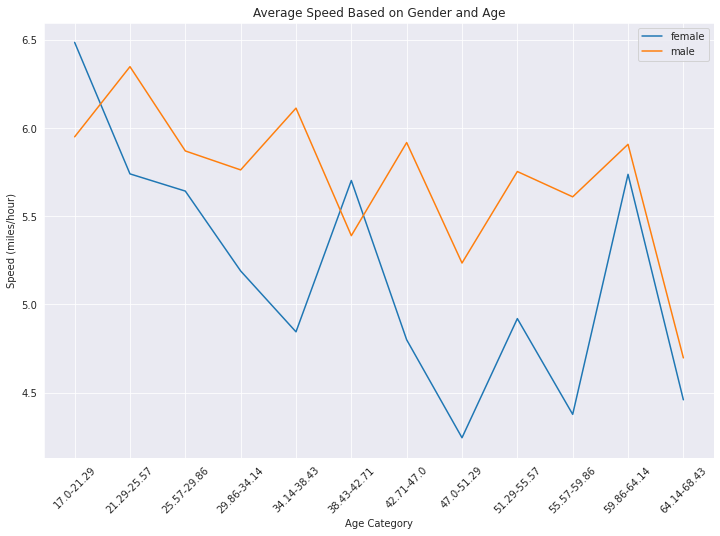

In [ ]:
#Barplot
plt.plot(speed_age_gender.cat2, speed_age_gender.female, label = "female")
plt.plot(speed_age_gender.cat2, speed_age_gender.male, label = "male")
plt.legend()
plt.xlabel('Age Category')
plt.ylabel('Speed (miles/hour)')
plt.title('Average Speed Based on Gender and Age')
plt.xticks(rotation=45)
plt.show()

In [ ]:
distance_age_gender = pd.concat([distance_age_gender_2015, distance_age_gender_2016, distance_age_gender_2017], axis=0)
distance_age_gender = distance_age_gender.groupby(['cat2']).mean()
distance_age_gender = pd.merge(distance_age_gender, age_bin, left_on='cat2', right_on='cat2', how='left').sort_values(by='cat')
distance_age_gender.drop(['bin', 'cat', 'bin2'], axis=1, inplace=True)

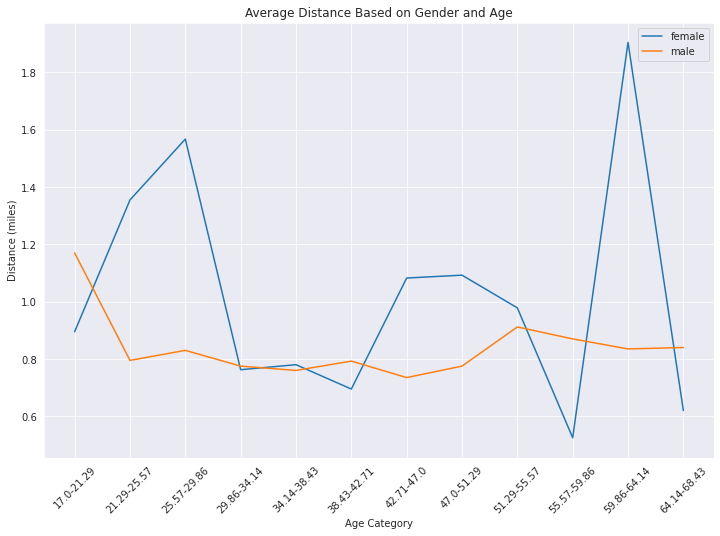

In [ ]:
#Barplot
plt.plot(distance_age_gender.cat2, distance_age_gender.female, label = "female")
plt.plot(distance_age_gender.cat2, distance_age_gender.male, label = "male")
plt.legend()
plt.xlabel('Age Category')
plt.ylabel('Distance (miles)')
plt.title('Average Distance Based on Gender and Age')
plt.xticks(rotation=45)
plt.show()

## Part 5: Busiest Bike by Times and Minutes Used

In [ ]:
#Bike usage based on number of times used
bike_use = pd.DataFrame()
bike_use = trips.groupby(['trips_year','bikeid']).size().reset_index(name = 'times_used')
bike_use = bike_use.sort_values('times_used', ascending = False)
bike_use['bikeid'] = bike_use['bikeid'].astype(int).astype(str)
bike_use['bikeid'] = ('Bike ' + bike_use['bikeid'])
bike_use = bike_use.groupby('bikeid').mean()['times_used'].reset_index(name = 'times_used').sort_values(by=['times_used'], ascending=False).head(10)
bike_use.head()

,bikeid,times_used
256,Bike 17801,1.000000
430,Bike 20527,1.000000
348,Bike 19169,0.666667
720,Bike 25556,0.666667
965,Bike 31102,0.666667


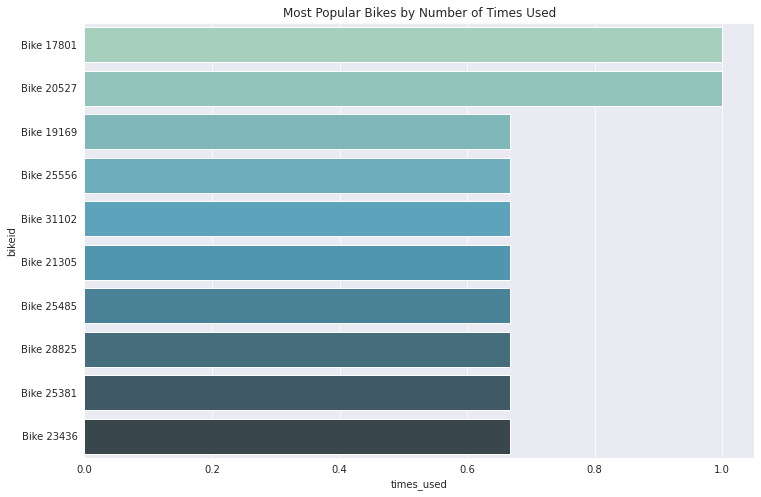

In [ ]:
#Barplot
ax2 = sns.barplot(x='times_used', y='bikeid', data = bike_use, palette="GnBu_d")
ax2.set_title('Most Popular Bikes by Number of Times Used', fontsize = 12)
plt.show()

In [ ]:
#Bike usage based on minutes used
bike_min = pd.DataFrame()
bike_min['sec_used'] = trips.groupby(['trips_year','bikeid'])['tripduration'].sum()
bike_min['min_used'] = round(bike_min['sec_used']/60,2)
bike_min = bike_min.sort_values('min_used', ascending = False).reset_index()
bike_min['bikeid'] = bike_min['bikeid'].astype(int).astype(str)
bike_min['bikeid'] = ('Bike ' + bike_min['bikeid'])
bike_min.drop(['sec_used'], axis = 1, inplace=True)
bike_min = bike_min.groupby('bikeid').mean()['min_used'].reset_index(name = 'min_used').sort_values(by=['min_used'], ascending=False).head(10)
bike_min.head()

,bikeid,min_used
391,Bike 19842,106.43
472,Bike 21188,55.85
144,Bike 16527,55.60
122,Bike 16164,54.82
479,Bike 21308,50.48


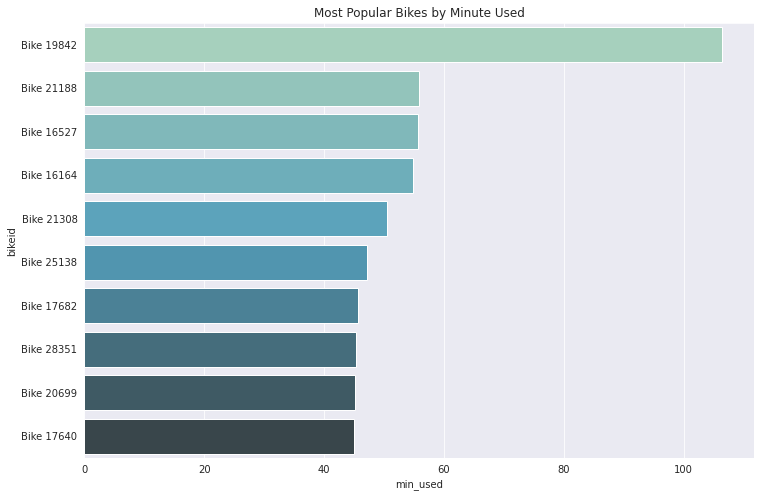

In [ ]:
#Barplot
ax2 = sns.barplot(x='min_used', y='bikeid', data = bike_min, palette="GnBu_d")
ax2.set_title('Most Popular Bikes by Minute Used', fontsize = 12)
plt.show()

## Part 6: Distribution Issue

### Rebalancing

In [ ]:
# Note that the end station id for one ride is the start station id for the next.
bike_journey = trips.sort_values(by=['bikeid','starttime'])

In [ ]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'), 'start_station_name':0,\
                       'stoptime': pd.to_datetime('2010-09-01'),'end_station_name':0,'bikeid':0},index=[0])

In [ ]:
bike_journey1 = pd.concat([offset,bike_journey]).reset_index(drop=True)
bike_journey2 = pd.concat([bike_journey,offset]).reset_index(drop=True)

In [ ]:
# if end_station_id != start_station_id -> rebalancing 
# Now each row shows the end of one trip and the start of the next.
# This is the time the bike spends at the station between rides.
bike_journey = pd.concat ([bike_journey1[['bikeid','stoptime','end_station_name']]\
                   ,bike_journey2[['bikeid','starttime','start_station_name']] ],\
                    axis=1 )
bike_journey.head()

,bikeid,stoptime,end_station_name,bikeid,starttime,start_station_name
0,0.0,2010-09-01 00:00:00,0,14534.0,2016-05-16 22:17:57,E 6 St & Avenue B
1,14534.0,2016-05-16 22:22:42,Shevchenko Pl & E 7 St,14570.0,2016-04-17 15:07:33,9 Ave & W 45 St
2,14570.0,2016-04-17 15:45:10,Amsterdam Ave & W 82 St,14576.0,2017-06-22 16:05:08,Franklin Ave & Myrtle Ave
3,14576.0,2017-06-22 16:13:15,Tompkins Ave & Hopkins St,14576.0,2017-07-21 20:30:10,Johnson St & Gold St
4,14576.0,2017-07-21 20:44:14,Dean St & 4 Ave,14583.0,2017-04-28 18:59:41,9 Ave & W 45 St


In [ ]:
bike_journey.columns = ['bikeid1','starttime','start_station_name','bikeid2','stoptime','end_station_name']

In [ ]:
bike_journey_rebal = bike_journey[['starttime','start_station_name','stoptime','end_station_name']].\
      loc[(bike_journey.bikeid1==bike_journey.bikeid2) & (bike_journey['start_station_name'] != bike_journey['end_station_name'])]
bike_journey_rebal.reset_index(drop=True, inplace=True)
bike_journey_rebal.head()

,starttime,start_station_name,stoptime,end_station_name
0,2017-06-22 16:13:15,Tompkins Ave & Hopkins St,2017-07-21 20:30:10,Johnson St & Gold St
1,2016-04-18 13:41:37,South End Ave & Liberty St,2017-06-12 19:14:06,Great Jones St
2,2015-07-11 11:21:39,Broadway & W 36 St,2015-09-28 13:34:01,W 53 St & 10 Ave
3,2016-07-17 12:22:11,W 13 St & 6 Ave,2017-05-04 12:38:22,1 Ave & E 15 St
4,2015-04-15 18:22:59,E 43 St & Vanderbilt Ave,2016-03-16 08:21:39,Hanson Pl & St Felix St


### Station Flow

In [ ]:
bjs=bike_journey_rebal[['starttime','start_station_name']].assign(in_out=-1) # act as -1 to indicate a bike pick-up
bje=bike_journey_rebal[['starttime','end_station_name']].assign(in_out=1) # act as 1 to indicate a drop off

In [ ]:
bjs.columns=['docktime','station_name','in_out']
bje.columns=['docktime','station_name','in_out']
bjse=pd.concat([bjs,bje]).sort_values(by=['station_name','docktime']).reset_index(drop=True)

In [ ]:
bjse.head()

,docktime,station_name,in_out
0,2016-07-17 12:22:11,1 Ave & E 15 St,1
1,2017-04-14 20:04:13,1 Ave & E 30 St,1
2,2017-05-09 18:16:52,1 Ave & E 62 St,1
3,2015-05-12 18:46:45,10 Ave & W 28 St,-1
4,2016-01-21 16:41:05,11 Ave & W 27 St,1


**Check the station table according its availability**

In [ ]:
id_name.head(3)

,station_id,station_name
0,261,Johnson St & Gold St
1,502,Henry St & Grand St
2,352,W 56 St & 6 Ave


In [ ]:
# getting bjse with its information
dummy = pd.merge(bjse, id_name, how='inner', left_on='station_name', right_on='station_name')
bjse_info = pd.merge(dummy, stations[['station_id','capacity','num_bikes_available', 'num_docks_available']], how='inner', left_on='station_id', right_on='station_id').drop('station_id', 1)

In [ ]:
bjse_info.head()

,docktime,station_name,in_out,capacity,num_bikes_available,num_docks_available
0,2016-07-17 12:22:11,1 Ave & E 15 St,1,54,46,6
1,2017-04-14 20:04:13,1 Ave & E 30 St,1,29,23,0
2,2017-05-09 18:16:52,1 Ave & E 62 St,1,45,40,5
3,2015-05-12 18:46:45,10 Ave & W 28 St,-1,49,32,16
4,2016-01-21 16:41:05,11 Ave & W 27 St,1,31,3,26


**Set the beginning inventory**

Set the num_bikes_availability as the value of beginning inventory

In [ ]:
begin_inventory = bjse_info.groupby('station_name').min()['num_bikes_available'].reset_index()

In [ ]:
begin_inventory['docktime'] = pd.Timestamp('2010-01-01T12')
begin_inventory = begin_inventory[['docktime', 'station_name', 'num_bikes_available']]
begin_inventory.rename(columns={'num_bikes_available': 'in_out'}, inplace=True)

In [ ]:
new_bjse = pd.concat([bjse, begin_inventory], axis=0).sort_values(by=['station_name', 'docktime']).reset_index(drop=True)

In [ ]:
new_bjse.head()

,docktime,station_name,in_out
0,2010-01-01 12:00:00,1 Ave & E 15 St,46
1,2016-07-17 12:22:11,1 Ave & E 15 St,1
2,2010-01-01 12:00:00,1 Ave & E 30 St,23
3,2017-04-14 20:04:13,1 Ave & E 30 St,1
4,2010-01-01 12:00:00,1 Ave & E 62 St,40


**Calculate the flow**

In [ ]:
new_bjse["cum_flow"]=new_bjse.groupby(['station_name'])['in_out'].cumsum(axis=0)

In [ ]:
new_bjse['date'] = pd.to_datetime(new_bjse['docktime']).dt.date

In [ ]:
new_bjse.head()

,docktime,station_name,in_out,cum_flow,date
0,2010-01-01 12:00:00,1 Ave & E 15 St,46,46,2010-01-01
1,2016-07-17 12:22:11,1 Ave & E 15 St,1,47,2016-07-17
2,2010-01-01 12:00:00,1 Ave & E 30 St,23,23,2010-01-01
3,2017-04-14 20:04:13,1 Ave & E 30 St,1,24,2017-04-14
4,2010-01-01 12:00:00,1 Ave & E 62 St,40,40,2010-01-01


### Checking Status

In [ ]:
# daily update
bjse_status_in_day = new_bjse.groupby(['station_name', 'date']).last().reset_index().drop(['docktime', 'in_out'], axis=1)

In [ ]:
# Put the capacity daily info
z = bjse_info[['station_name','capacity']].drop_duplicates()
new2_bjse= pd.merge(bjse_status_in_day, z, how='inner', left_on='station_name', right_on='station_name')

In [ ]:
new2_bjse.loc[(new2_bjse['cum_flow'] < 0), 'inventory'] = 'SHORTAGE'
new2_bjse.loc[(new2_bjse['cum_flow'] == 0), 'inventory'] = 'BALANCE'
new2_bjse.loc[(new2_bjse['cum_flow'] > 0), 'inventory'] = 'SUPRLUS'
new2_bjse.loc[(new2_bjse['cum_flow'] <= new2_bjse['capacity']), 'load'] = 'UNDER'
new2_bjse.loc[(new2_bjse['cum_flow'] > new2_bjse['capacity']), 'load'] = 'OVER'  

In [ ]:
new2_bjse['year'] = pd.DatetimeIndex(new2_bjse['date']).year

In [ ]:
new2_bjse["status_name"] = new2_bjse["inventory"].astype(str) + " - " + new2_bjse["load"].astype(str)

In [ ]:
# count frequency of condition in a year
bjse_status_in_year = new2_bjse.groupby(['station_name','year','status_name']).count()['capacity'].reset_index(name='status_count')

In [ ]:
bjse_status_in_year.drop(bjse_status_in_year[bjse_status_in_year['year'] == 2010].index, inplace = True)

In [ ]:
bjse_status_in_year.head()

,station_name,year,status_name,status_count
1,1 Ave & E 15 St,2016,SUPRLUS - UNDER,1
3,1 Ave & E 30 St,2017,SUPRLUS - UNDER,1
5,1 Ave & E 62 St,2017,SUPRLUS - UNDER,1
7,10 Ave & W 28 St,2015,SUPRLUS - UNDER,1
9,11 Ave & W 27 St,2016,SUPRLUS - UNDER,1


In [ ]:
sum_distrib = pd.pivot_table(bjse_status_in_year,index=['station_name','year'],columns=['status_name'],values=['status_count'],aggfunc=np.sum).fillna(0)
sum_distrib = pd.DataFrame(sum_distrib.to_records())
sum_distrib.head(2)

,station_name,year,"('status_count', 'BALANCE - UNDER')","('status_count', 'SHORTAGE - UNDER')","('status_count', 'SUPRLUS - OVER')","('status_count', 'SUPRLUS - UNDER')"
0,1 Ave & E 15 St,2016,0.0,0.0,0.0,1.0
1,1 Ave & E 30 St,2017,0.0,0.0,0.0,1.0


In [ ]:
sum_distrib.columns = ['station_name', 'year', 'BALANCE-UNDER', 'SHORTAGE-UNDER', 'SURPLUS-OVER', 'SURPLUS-UNDER']

In [ ]:
# summary distribution status per year
sum_distrib_per_year=sum_distrib.groupby(['year']).agg({'BALANCE-UNDER':'sum','SHORTAGE-UNDER':'sum','SURPLUS-OVER':'sum','SURPLUS-UNDER':'sum'}).reset_index()
sum_distrib_per_year

,year,BALANCE-UNDER,SHORTAGE-UNDER,SURPLUS-OVER,SURPLUS-UNDER
0,2015,1.0,0.0,0.0,26.0
1,2016,0.0,1.0,1.0,18.0
2,2017,0.0,1.0,0.0,22.0


In [ ]:
bjse_status_in_year_visual = bjse_status_in_year.groupby(['year','status_name']).sum()['status_count'].reset_index()
bjse_status_in_year_visual.head()

,year,status_name,status_count
0,2015,BALANCE - UNDER,1
1,2015,SUPRLUS - UNDER,26
2,2016,SHORTAGE - UNDER,1
3,2016,SUPRLUS - OVER,1
4,2016,SUPRLUS - UNDER,18


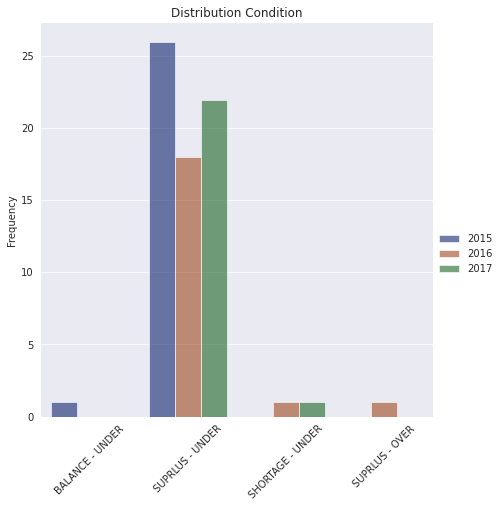

In [ ]:
g = sns.catplot(
    data=bjse_status_in_year_visual, kind="bar",
    x="status_name", y="status_count", hue="year",
    ci="sd", palette="dark", alpha=.6, height=6
    )
g.despine(left=True)
g.set_axis_labels("", "Frequency")
g.legend.set_title("")
plt.title("Distribution Condition")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# summary distribution status per station in 2017
new2_bjse_xyear = new2_bjse[new2_bjse['year']==2017]
new2_bjse_xyear = new2_bjse_xyear.groupby(['station_name']).agg({'cum_flow':'mean','capacity':'mean'}).reset_index()

In [ ]:
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] == 0) & (new2_bjse_xyear['cum_flow'] <= new2_bjse_xyear['capacity']), 'condition'] = 'BALANCE-UNDER'
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] < 0) & (new2_bjse_xyear['cum_flow'] <= new2_bjse_xyear['capacity']), 'condition'] = 'SHORTAGE-UNDER'
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] > 0) & (new2_bjse_xyear['cum_flow'] > new2_bjse_xyear['capacity']), 'condition'] = 'SURPLUS-OVER'
new2_bjse_xyear.loc[(new2_bjse_xyear['cum_flow'] > 0) & (new2_bjse_xyear['cum_flow'] <= new2_bjse_xyear['capacity']), 'condition'] = 'SURPLUS-UNDER'
new2_bjse_xyear.head()

,station_name,cum_flow,capacity,condition
0,1 Ave & E 30 St,24,29,SURPLUS-UNDER
1,1 Ave & E 62 St,41,45,SURPLUS-UNDER
2,5 St & 6 Ave,9,23,SURPLUS-UNDER
3,Berry St & N 8 St,3,27,SURPLUS-UNDER
4,Broadway & E 22 St,-1,0,SHORTAGE-UNDER


In [ ]:
balance_under = new2_bjse_xyear[new2_bjse_xyear['condition']=='BALANCE-UNDER'].sort_values(by=['cum_flow'], ascending=False)
shortage_under = new2_bjse_xyear[new2_bjse_xyear['condition']=='SHORTAGE-UNDER'].sort_values(by=['cum_flow'], ascending=True)
surplus_over = new2_bjse_xyear[new2_bjse_xyear['condition']=='SURPLUS-OVER'].sort_values(by=['cum_flow'], ascending=False)
surplus_under = new2_bjse_xyear[new2_bjse_xyear['condition']=='SURPLUS-UNDER'].sort_values(by=['cum_flow'], ascending=False)

In [ ]:
print(len(surplus_under))
print(len(shortage_under))

22
1


In [ ]:
surplus_under.loc["Total", "cum_flow"] = surplus_under.cum_flow.sum()
surplus_under.tail(1)

,station_name,cum_flow,capacity,condition
Total,NaN,536.0,NaN,NaN


In [ ]:
shortage_under.loc["Total", "cum_flow"] = shortage_under.cum_flow.sum()
shortage_under.tail(1)

,station_name,cum_flow,capacity,condition
Total,NaN,-1.0,NaN,NaN


It is still possible to distribute from surplus_under to shortage_under

In [ ]:
q_surplus_under = surplus_under.quantile([.1, .25, .5, .75], axis = 0)
q2_surplus_under = q_surplus_under.iloc[1,0]
q3_surplus_under = q_surplus_under.iloc[2,0]

In [ ]:
def f(row):
    if row['cum_flow'] < q2_surplus_under:
        val = 'low'
    elif row['cum_flow'] > q3_surplus_under:
        val = 'high'
    else:
        val = 'medium'
    return val

surplus_under['priority'] = surplus_under.apply(f, axis=1)

In [ ]:
surplus_under.head()

,station_name,cum_flow,capacity,condition,priority
14,Lispenard St & Broadway,76.0,79.0,SURPLUS-UNDER,high
7,E 2 St & 2 Ave,53.0,58.0,SURPLUS-UNDER,high
10,Grand St & Greene St,52.0,65.0,SURPLUS-UNDER,high
13,Lexington Ave & E 24 St,41.0,53.0,SURPLUS-UNDER,high
1,1 Ave & E 62 St,41.0,45.0,SURPLUS-UNDER,high


In [ ]:
surplus_under_visual = surplus_under.dropna().groupby(['priority']).size().reset_index(name='count')
surplus_under_visual

,priority,count
0,high,10
1,low,5
2,medium,7


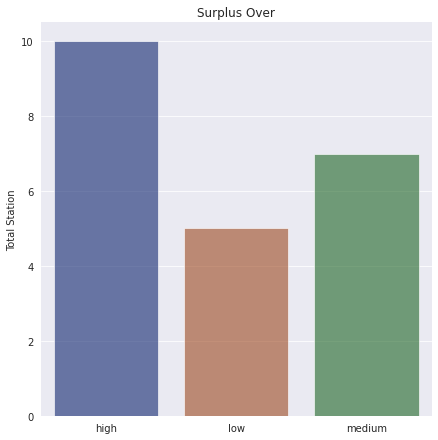

In [ ]:
h = sns.catplot(
    data=surplus_under_visual, kind="bar",
    x="priority", y="count",
    ci="sd", palette="dark", alpha=.6, height=6
    )
h.despine(left=True)
h.set_axis_labels("", "Total Station")
plt.title("Surplus Over")
plt.show()

In [ ]:
q_shortage_under = shortage_under.quantile([.1, .25, .5, .75], axis = 0)
q2_shortage_under = q_shortage_under.iloc[1,0]
q3_shortage_under = q_shortage_under.iloc[2,0]

In [ ]:
def f(row):
    if row['cum_flow'] < q2_shortage_under:
        val = 'high'
    elif row['cum_flow'] > q3_shortage_under:
        val = 'low'
    else:
        val = 'medium'
    return val

shortage_under['priority'] = shortage_under.apply(f, axis=1)

In [ ]:
shortage_under.head()

,station_name,cum_flow,capacity,condition,priority
4,Broadway & E 22 St,-1.0,0.0,SHORTAGE-UNDER,medium
Total,NaN,-1.0,NaN,NaN,medium


In [ ]:
shortage_under_visual = shortage_under.dropna().groupby(['priority']).size().reset_index(name='count')
shortage_under_visual

,priority,count
0,medium,1


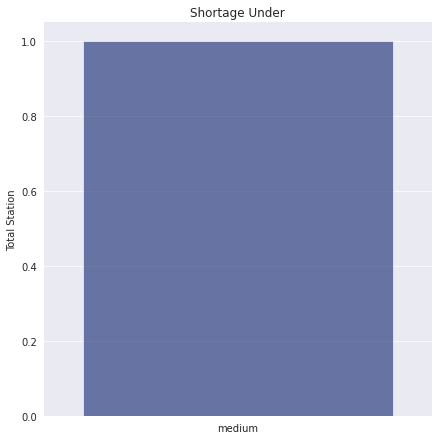

In [ ]:
h = sns.catplot(
    data=shortage_under_visual, kind="bar",
    x="priority", y="count",
    ci="sd", palette="dark", alpha=.6, height=6
    )
h.despine(left=True)
h.set_axis_labels("", "Total Station")
plt.title("Shortage Under")
plt.show()

###Check the strange value

In [ ]:
k = new_bjse.groupby(['station_name', 'date']).last().reset_index()
k.head()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
k[k['station_name']=='1 Ave & E 15 St']